### Improved MNIST Digit Classifier:
The following 3-layer MNIST network with 100 nodes in the hidden layer uses $\texttt{tanh}$ as the activation function for the hidden layer and softmax as the activation function for the output layer. It also applies batch gradient descent &mdash; updating weights after a batch of datapoints are trained on &mdash; and dropout regularisation &mdash; randomly switching off nodes to train subsections of the neural network (to combat overfitting).

This network omits the error function.


I:0 Test-Acc:0.394 Train-Acc:0.156
I:10 Test-Acc:0.6867 Train-Acc:0.723
I:20 Test-Acc:0.7025 Train-Acc:0.732
I:30 Test-Acc:0.734 Train-Acc:0.763
I:40 Test-Acc:0.7663 Train-Acc:0.794
I:50 Test-Acc:0.7913 Train-Acc:0.819
I:60 Test-Acc:0.8102 Train-Acc:0.849
I:70 Test-Acc:0.8228 Train-Acc:0.864
I:80 Test-Acc:0.831 Train-Acc:0.867
I:90 Test-Acc:0.8364 Train-Acc:0.885
I:100 Test-Acc:0.8407 Train-Acc:0.883
I:110 Test-Acc:0.845 Train-Acc:0.891
I:120 Test-Acc:0.8481 Train-Acc:0.901
I:130 Test-Acc:0.8505 Train-Acc:0.901
I:140 Test-Acc:0.8526 Train-Acc:0.905
I:150 Test-Acc:0.8555 Train-Acc:0.914
I:160 Test-Acc:0.8577 Train-Acc:0.925
I:170 Test-Acc:0.8596 Train-Acc:0.918
I:180 Test-Acc:0.8619 Train-Acc:0.933
I:190 Test-Acc:0.863 Train-Acc:0.933
I:200 Test-Acc:0.8642 Train-Acc:0.926
I:210 Test-Acc:0.8653 Train-Acc:0.931
I:220 Test-Acc:0.8668 Train-Acc:0.93
I:230 Test-Acc:0.8672 Train-Acc:0.937
I:240 Test-Acc:0.8681 Train-Acc:0.938
I:250 Test-Acc:0.8687 Train-Acc:0.937
I:260 Test-Acc:0.8684 Train-

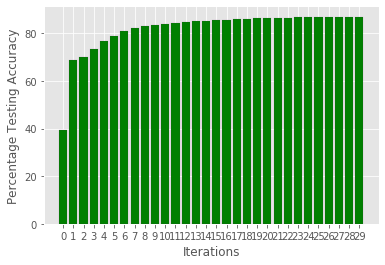

In [45]:
import sys
import numpy as np
import matplotlib.pyplot as plt
from keras.datasets import mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Reshaping the training images (28x28 pixels) into a 1D array, then scaling down all the pixel values 
# from 0-255 to 0-1
images, labels = (x_train[0 : 1000].reshape(1000, 28 * 28) / 255, y_train[0 : 1000])
test_images = x_test.reshape(len(x_test), 28 * 28) / 255

# Formatting the training and testing labels matrices
one_hot_labels = np.zeros((len(labels), 10))
for i, eachLabel in enumerate(labels):
    # Marking which output is 'hot'
    one_hot_labels[i][eachLabel] = 1
labels = one_hot_labels

test_labels = np.zeros((len(y_test), 10))
for i, eachLabel in enumerate(y_test):
    test_labels[i][eachLabel] = 1

# Initialising the randomised weights
# Note that tanh works better on randomised weights in a narrower range. Here we'll scale the weight values
# from [0, 1] to the narrower range [-0.01, 0.01] for weights_0_1
np.random.seed(1)
weights_0_1 = 0.02 * np.random.random((pixels_per_image, hidden_size)) - 0.01 

# Range [-0.1, 0.1] for the second weight matrix
weights_1_2 = 0.2 * np.random.random((hidden_size, num_labels)) - 0.1

# Activation functions: 
def tanh(x):
    return np.tanh(x)

def tanh2derivative(x):
    return 1 - (x ** 2)
    
def tanh2deriv(x):
    return 1 - (x ** 2)

def softmax(x):
    tmp = np.exp(x)
    return tmp / np.sum(tmp, axis=1, keepdims=True)

# Parameters
alpha = 2
iterations = 300
hidden_size = 100
pixels_per_image, num_labels = (784, 10)
batch_size = 100

y_seq = []
for iteration in range(iterations):
    correct_count = 0
    # Looping through 10 batches of 100 images
    for i in range(int(len(images) / batch_size)):
        batch_start, batch_end = ((i * batch_size),((i+1)*batch_size))
        curr_batch = images[batch_start : batch_end]
        layer_0 = curr_batch
        layer_1 = tanh(np.dot(layer_0, weights_0_1))
        dropout_mask = np.random.randint(2, size=layer_1.shape)
        layer_1 *= dropout_mask * 2
        layer_2 = softmax(np.dot(layer_1, weights_1_2))
        
        for j in range(batch_size):
            correct_count += int(np.argmax(layer_2[j:j+1]) == np.argmax(labels[batch_start+j:batch_start+j+1]))
        layer_2_delta = (labels[batch_start:batch_end]-layer_2) / (batch_size * layer_2.shape[0])
        layer_1_delta = layer_2_delta.dot(weights_1_2.T) * tanh2deriv(layer_1)
        # Apply the dropout_mask on the backpropagated deltas.
        # We don't want to attribute error to nodes that were switched off in forward propagation!
        layer_1_delta *= dropout_mask
        
        # Updating the weights after each batch completes:
        weights_1_2 += alpha * layer_1.T.dot(layer_2_delta)
        weights_0_1 += alpha * layer_0.T.dot(layer_1_delta)
    
    test_correct_count = 0
    for i in range(len(test_images)):
        layer_0 = test_images[i : i + 1]
        layer_1 = tanh(np.dot(layer_0, weights_0_1))
        layer_2 = softmax(np.dot(layer_1, weights_1_2))
        test_correct_count += int(np.argmax(layer_2) == np.argmax(test_labels[i : i + 1]))
    
    if (iteration % 10 == 0):
        sys.stdout.write("\n"+ "I:" + str(iteration) + \
                         " Test-Acc:"+str(test_correct_count / float(len(test_images)))+\
                         " Train-Acc:" + str(correct_count / float(len(images))))
        y_seq.append(test_correct_count / float(len(test_images)))

# Plotting the testing accuracy over each iteration:
x_pos = [i for i in range(int(iterations / 10))]
y_seq = list(map(lambda x: x * 100, y_seq))
plt.style.use('ggplot')
plt.bar(x_pos, y_seq,linewidth=0.1, color="green", edgecolor="purple")
plt.xlabel("Iterations")
plt.ylabel("Percentage Testing Accuracy")
plt.xticks(x_pos, x_pos)
plt.show()